🦋I used the DCGAN tutorial on the tensorflow official website to complete the training, using a butterfly dataset I made myself, and the pictures came from pinterest and the butterfly and moth dataset. This is my first attempt at making my own dataset, and the first time importing my own dataset into a model.

🦋I want to make DCGAN generate new butterfly pictures by learning pictures of butterflies. Some butterfly illustrations and specimens are also included in the data set for DCGAN to learn together.

🦋If you want to run this notebook, just drag and drop the butterfly dataset zip file to the content folder in colab.

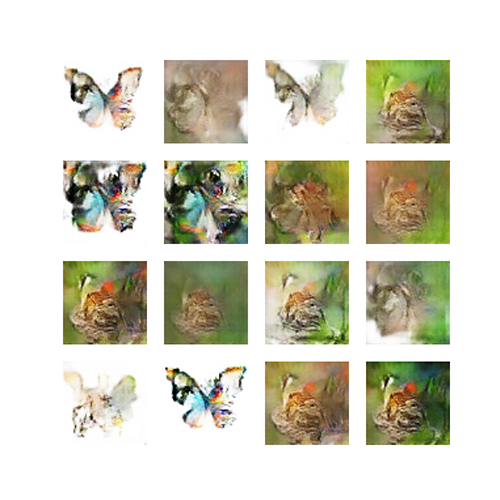

🦋Original code: https://www.tensorflow.org/tutorials/generative/dcgan?hl=zh-cn

# BUTTERFLY🦋🦋🦋【蝴蝶】

### 🦋SET UP

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.12.0'

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_o3ergss
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-_o3ergss
  Resolved https://github.com/tensorflow/docs to commit 82c1d10782be2714b3ece1f59c05082195474ce9
  Preparing metadata (setup.py) ... done


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### 🦋Load and prepare the dataset

Import the butterfly dataset I made.

In [ ]:
import zipfile

from PIL import Image
zip_path = '/content/butterfly.zip'  # Specify the ZIP file path of the dataset
extract_path = '/content'  # Unzip the compressed file and save the image to a new file

with zipfile.ZipFile(zip_path, 'r') as zip_file:
    zip_file.extractall(extract_path)

image_files = os.listdir(extract_path)

In [ ]:
def load_image(file_path):
    image = Image.open(file_path)
    image = np.array(image)
    return image

In [ ]:
# Define the folder path to the folder of the output image
folder_path = '/content/butterfly'

# Read all image files in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]

# Load image data
train_images = []
for file in image_files:
    image = load_image(file)  # load image
    train_images.append(image)

# Convert list to NumPy array
train_images = np.array(train_images)

In [ ]:
import cv2

image = cv2.imread('/content/butterfly/picture-000.jpg')
print(image.shape)  # The shape of the output image

(64, 64, 3)


In [ ]:
print('/content/sample_data')  # output image path
print(image)  # output image

/content/sample_data
[[[255 254 240]
  [254 253 239]
  [255 253 243]
  ...
  [255 255 249]
  [253 252 248]
  [255 253 248]]

 [[255 254 240]
  [255 255 241]
  [255 253 243]
  ...
  [255 254 250]
  [254 254 248]
  [255 254 244]]

 [[255 253 242]
  [255 253 242]
  [254 252 244]
  ...
  [255 253 248]
  [255 252 247]
  [255 254 246]]

 ...

 [[255 255 239]
  [254 253 239]
  [255 254 240]
  ...
  [224 230 213]
  [226 234 217]
  [231 237 220]]

 [[255 254 240]
  [255 255 239]
  [255 254 240]
  ...
  [235 241 222]
  [238 241 225]
  [236 244 227]]

 [[254 253 239]
  [254 254 236]
  [254 253 239]
  ...
  [243 246 230]
  [244 247 231]
  [246 250 231]]]


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 64, 64, 3).astype('float32') # Image size
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 16 # Because the number of images in the data set is about 3,000, it is more appropriate to set the batch size to 16

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 🦋Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### 🦋The Generator

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 64x64x3. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

In [ ]:
# I increased the number of layers to fit the data set image size

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 256)))
    assert model.output_shape == (None, 4, 4, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

Use the (as yet untrained) generator to create an image.

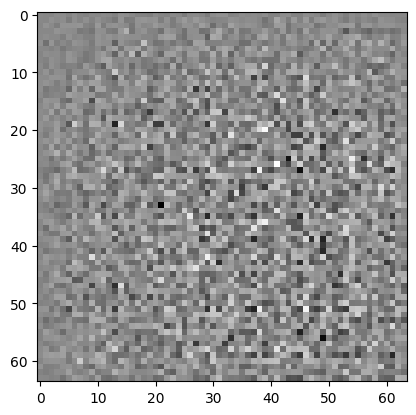

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### 🦋The Discriminator

The discriminator is a CNN-based image classifier.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3])) # Image size
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00053816]], shape=(1, 1), dtype=float32)


## 🦋Define the loss and optimizers

Define loss functions and optimizers for both models.


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 🦋Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 🦋Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 🦋Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 🦋Define the training loop


In [ ]:
EPOCHS = 500 # Train 500 times
noise_dim = 100
num_examples_to_generate = 16


seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10, 10))# Image size

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      img_arr = predictions[i].numpy()
      plt.imshow((img_arr[:, :, :] * 127.5 + 127.5).astype(np.uint8))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model

🦋🦋🦋

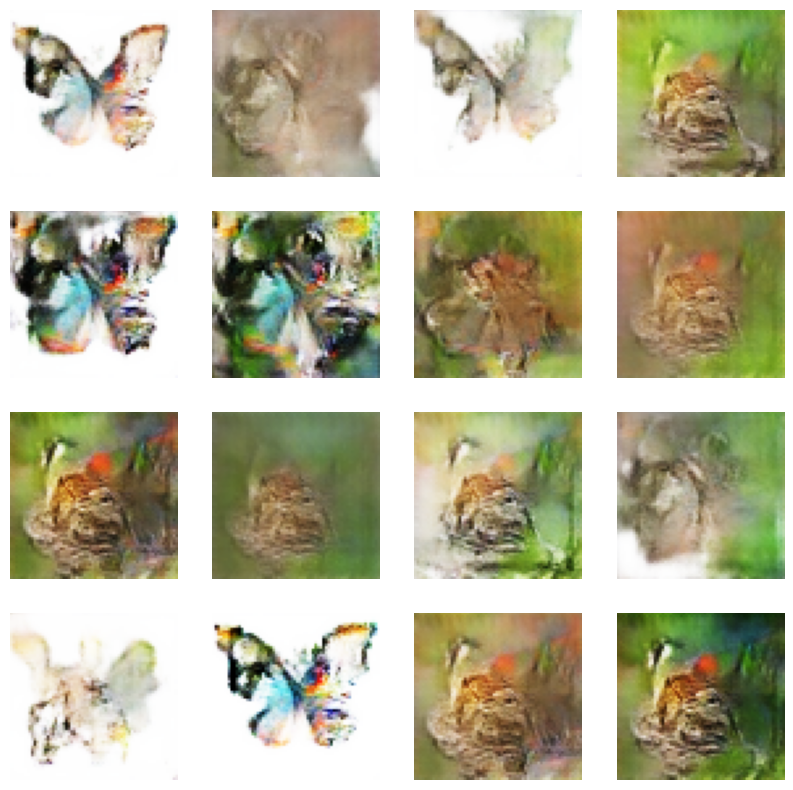

In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))